# Cats and Dogs from [CIFAR10](https://keras.io/datasets/)!

In [8]:
# numpy and plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# keras
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# getting the datset
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import backend as K

** Load Cats and Dogs From CIFAR10 dataset **

First we load the CIFAR10 data and extract all cats and dogs from it.

x_train shape: (10000, 32, 32, 3)
10000 train samples
2000 test samples
channels_last


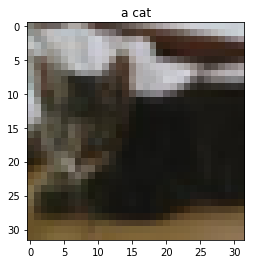

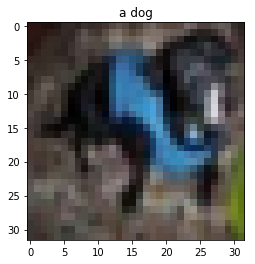

In [9]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Reduce to cats and dogs
def extract(x,y,labels):
    arg_train = []
    new_y = np.zeros(np.max(labels)+1)
    for i,l in enumerate(labels):
        arg_train.append(np.argwhere(y == l)[:,0])
        new_y[l] = i
    arg_train = np.concatenate(arg_train)
    return x[arg_train], new_y[y[arg_train]]
    
x_train, y_train = extract(x_train, y_train, [3,5])
x_test, y_test = extract(x_test, y_test, [3,5])

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# maximum value normalization
x_train /= 255
x_test /= 255

img_rows, img_cols, channels = x_train.shape[1:]

print(K.image_data_format())
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)

plt.imshow(x_train[np.argmax(y_train==0)])
plt.title("a cat")
plt.show()
plt.imshow(x_train[np.argmax(y_train==1)])
plt.title("a dog")
plt.show()

Next, we just define a function which will display the results later.

In [10]:
def predict(idx, model, data, avg=None, norm=None, cols=5, threshold=.3):
    try:
        idx = list(idx)
    except:
        idx = [idx]
        
    cats = 0
    dogs = 0
    data = data[idx]
    if norm is None:
        p = model.predict(data)
    else:
        p = model.predict(data/norm)
    i = 0
    while i < p.shape[0]:
        fig, axs = plt.subplots(1,cols,figsize=(5*cols,5))
        fig.figsize=(20,10)
        for ax in axs:
            if avg is not None:
                img = (data[i]+avg)
            else:
                img = (data[i])

            ax.imshow(img)
            if p[i] < threshold:
                label = "cat"
                cats += 1
            elif p[i] > 1-threshold:
                label = "dog"
                dogs += 1
            else:
                label = "not sure"
            ax.text(.5,0, label+ "; score = " + str(p[i]),
                    horizontalalignment='center', verticalalignment='bottom', transform=ax.axes.transAxes,
                    backgroundcolor="white", size="large")
            i += 1
            if i >= p.shape[0]:
                break
        plt.show()
    print(cats, " cats (", cats/len(idx)*100., "%),", dogs, " dogs (", dogs/len(idx)*100., "%)")

In [11]:
batch_size = 128

# Convolutional Neural Network

A very simple CNN... (> 70% validation accuray after 10 epochs)

In [14]:
model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

# model.summary()

We will train for ten epochs (iterations ofer the whole training data)...

In [15]:
model1.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 11s 1ms/sample - loss: 0.6685 - accuracy: 0.5905 - val_loss: 0.6260 - val_accuracy: 0.6590
Epoch 2/10
10000/10000 [==============================] - 0s 44us/sample - loss: 0.6063 - accuracy: 0.6653 - val_loss: 0.5854 - val_accuracy: 0.6850
Epoch 3/10
10000/10000 [==============================] - 0s 43us/sample - loss: 0.5601 - accuracy: 0.7136 - val_loss: 0.5406 - val_accuracy: 0.7190
Epoch 4/10
10000/10000 [==============================] - 0s 44us/sample - loss: 0.5177 - accuracy: 0.7424 - val_loss: 0.5503 - val_accuracy: 0.7230
Epoch 5/10
10000/10000 [==============================] - 0s 43us/sample - loss: 0.4779 - accuracy: 0.7669 - val_loss: 0.5260 - val_accuracy: 0.7315
Epoch 6/10
10000/10000 [==============================] - 0s 44us/sample - loss: 0.4140 - accuracy: 0.8073 - val_loss: 0.5299 - val_accuracy: 0.7305
Epoch 7/10
10000/10000 [==============================] -

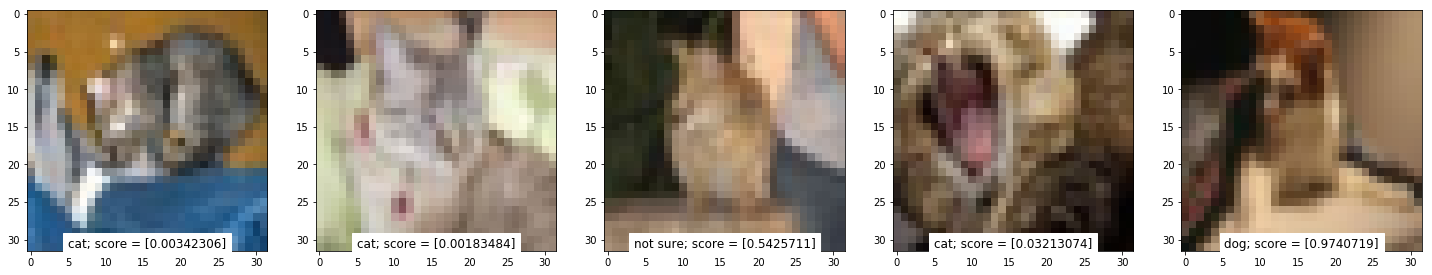

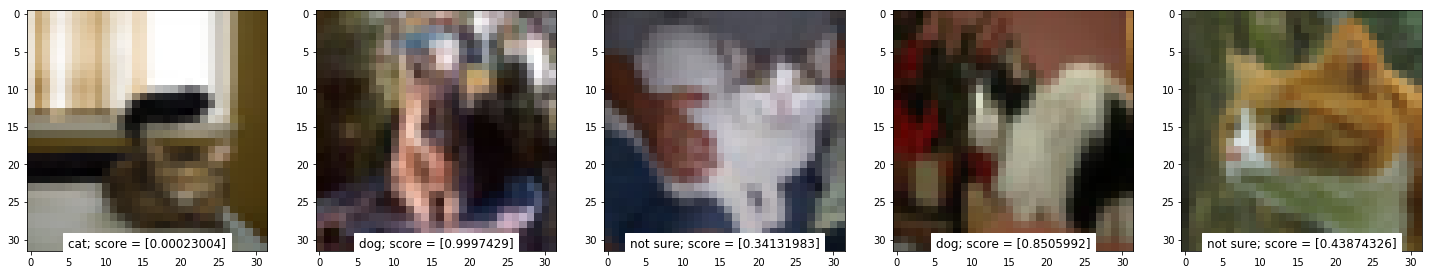

4  cats ( 40.0 %), 3  dogs ( 30.0 %)


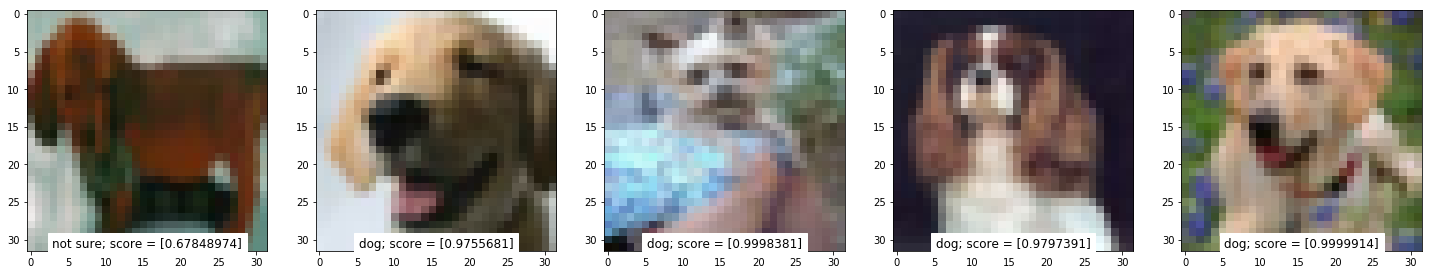

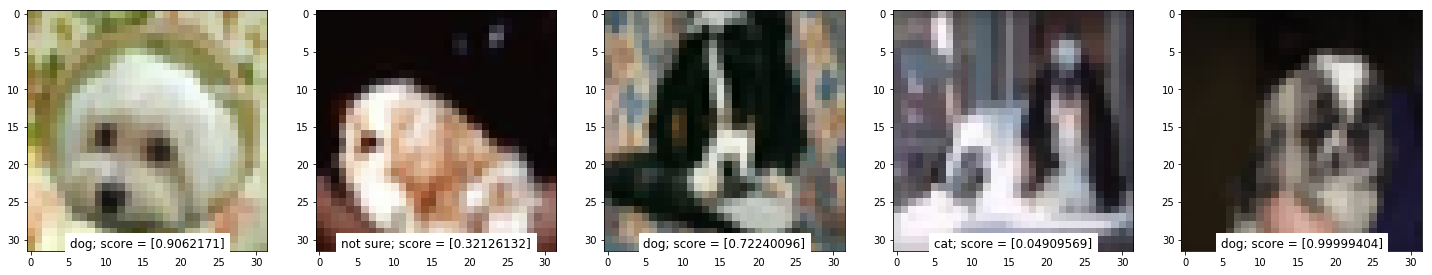

1  cats ( 10.0 %), 7  dogs ( 70.0 %)


In [16]:
predict(range(10), model1, x_test)
predict(range(x_test.shape[0]-10, x_test.shape[0]), model1, x_test)

A rather simple CNN: Deeper than the one above, but actually with fewer trainable parameters. It gives slightly better performance.

In [18]:
model2 = Sequential()
model2.add(Conv2D(48, kernel_size=(5, 5), padding="same",
                 activation='relu', input_shape=input_shape))
model2.add(Conv2D(32, (5, 5), activation='relu', padding="same"))
model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
model2.add(Conv2D(96, (5, 5), activation='relu', padding="same"))
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
model2.add(Conv2D(160, (3, 3), activation='relu', padding="same"))
model2.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
model2.add(Conv2D(256, (3, 3), activation='relu', padding="same"))
model2.add(Flatten())
model2.add(Dropout(.3))
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(.5))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(1))
model2.add(Activation('sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

# model.summary()

In [19]:
model2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 3s 280us/sample - loss: 0.7241 - accuracy: 0.5472 - val_loss: 0.6884 - val_accuracy: 0.5445
Epoch 2/10
10000/10000 [==============================] - 1s 98us/sample - loss: 0.6643 - accuracy: 0.5973 - val_loss: 0.6800 - val_accuracy: 0.5625
Epoch 3/10
10000/10000 [==============================] - 1s 98us/sample - loss: 0.6219 - accuracy: 0.6516 - val_loss: 0.6551 - val_accuracy: 0.6305
Epoch 4/10
10000/10000 [==============================] - 1s 98us/sample - loss: 0.5751 - accuracy: 0.6950 - val_loss: 0.6021 - val_accuracy: 0.6785
Epoch 5/10
10000/10000 [==============================] - 1s 99us/sample - loss: 0.5272 - accuracy: 0.7302 - val_loss: 0.5795 - val_accuracy: 0.6990
Epoch 6/10
10000/10000 [==============================] - 1s 99us/sample - loss: 0.4897 - accuracy: 0.7560 - val_loss: 0.6134 - val_accuracy: 0.6265
Epoch 7/10
10000/10000 [==============================] 

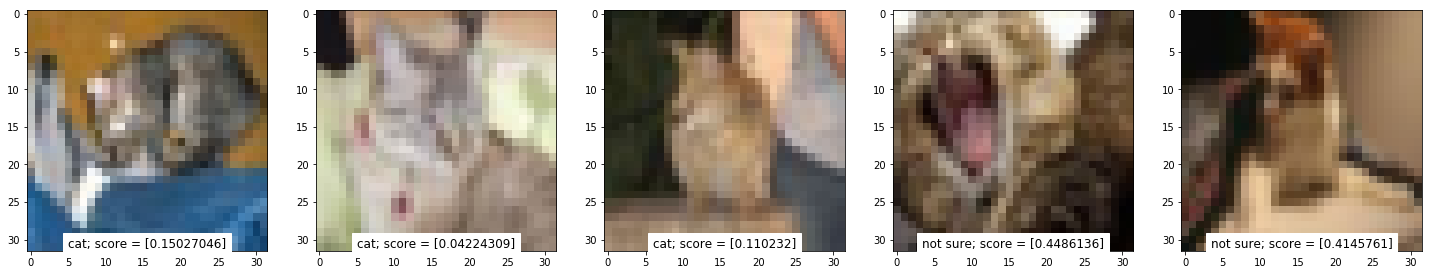

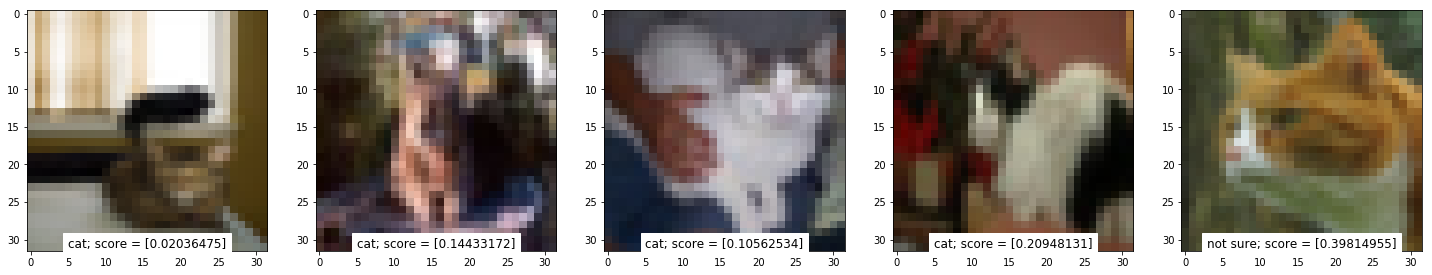

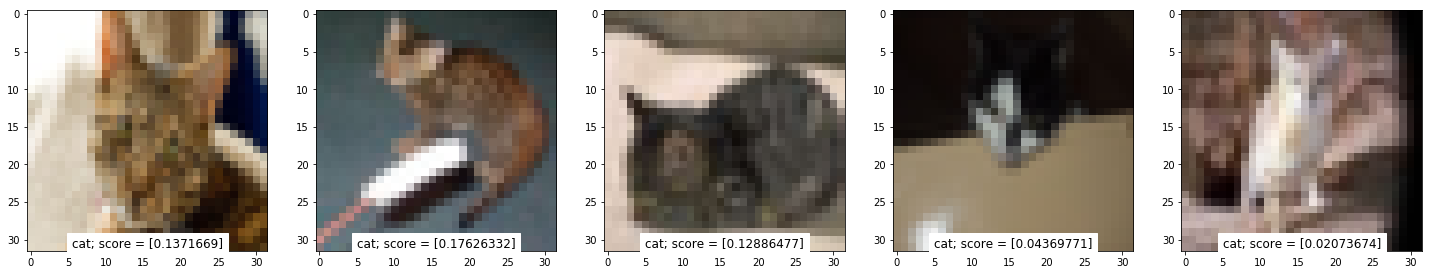

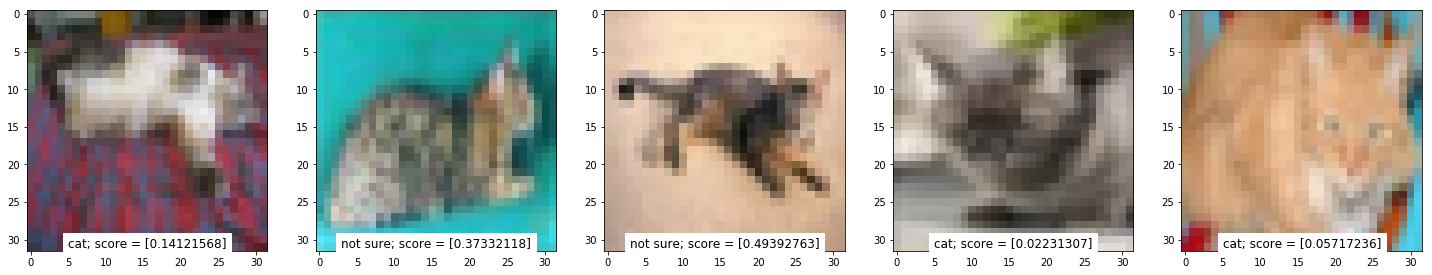

15  cats ( 75.0 %), 0  dogs ( 0.0 %)


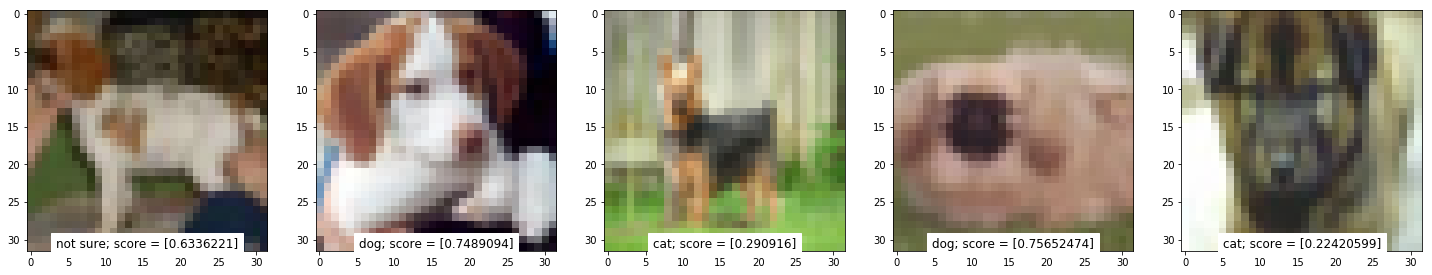

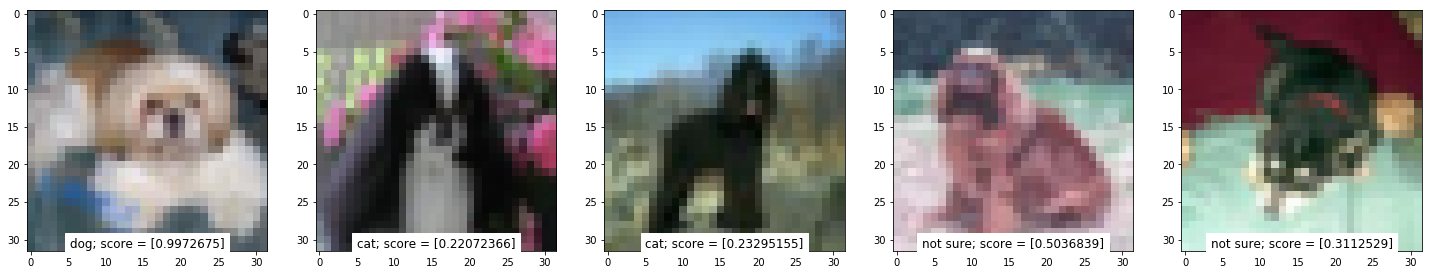

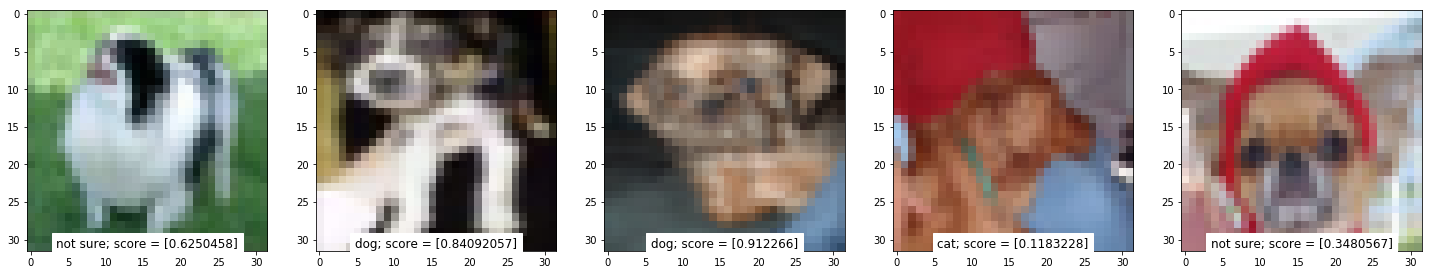

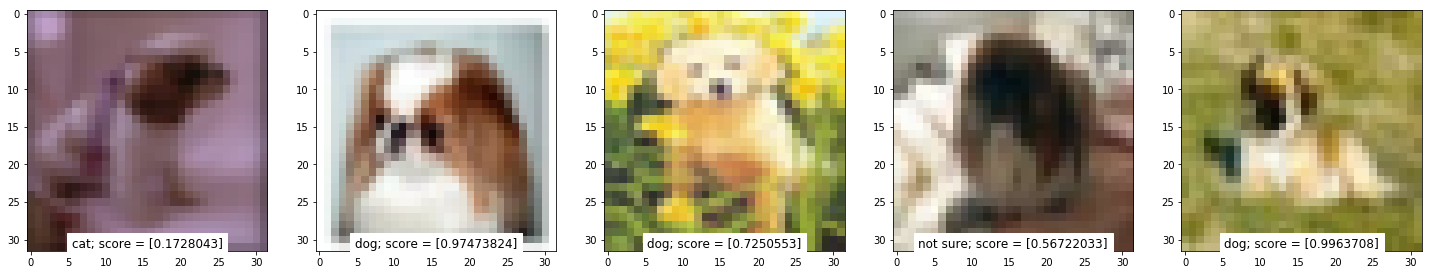

6  cats ( 30.0 %), 8  dogs ( 40.0 %)


In [20]:
predict(range(20), model2, x_test)
predict(range(x_test.shape[0]//2, x_test.shape[0]//2+20), model2, x_test)

## Data Augmentation

Looking at the training progress we can see, that in the end the loss decreases but the validation loss does not. The network is only optimized for the training data. The test data is used to validate the performance on unseen images. What we observe here is called overfitting. This problem will be adressed in depth in the session on regularization.

One simple explanation for the phenomenon in our case is, that we have limited training data over which we interate over and over and many parameters in our network which can *memorize* the data. One way to get more data is augmenting the available data with randomly transformed data which stil retains the same labels.

In [21]:
from keras.preprocessing.image import ImageDataGenerator

# traning data is augmented
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow(x_train, y_train,
    batch_size=batch_size)

With the augmented training data we can continue training and improve the results on the test set.

In [22]:
model2.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=(x_test, y_test))

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 15 steps, validate on 2000 samples
Epoch 1/50
15/15 [==============================] - 2s 106ms/step - loss: 0.4324 - accuracy: 0.7948 - val_loss: 0.6412 - val_accuracy: 0.6475
Epoch 2/50
15/15 [==============================] - 1s 67ms/step - loss: 0.4380 - accuracy: 0.7854 - val_loss: 0.5278 - val_accuracy: 0.7405
Epoch 3/50
15/15 [==============================] - 1s 65ms/step - loss: 0.4308 - accuracy: 0.7998 - val_loss: 0.5166 - val_accuracy: 0.7540
Epoch 4/50
15/15 [==============================] - 1s 70ms/step - loss: 0.4440 - accuracy: 0.7844 - val_loss: 0.4686 - val_accuracy: 0.7755
Epoch 5/50
15/15 [==============================] - 1s 66ms/step - loss: 0.4092 - accuracy: 0.8003 - val_loss: 0.4711 - val_accuracy: 0.7800
Epoch 6/50
15/15 [==============================] - 1s 74ms/step - loss: 0.4199 - accuracy: 0.8109 - val_loss: 0.5029 - val_accuracy: 0.7595
Epoch 7

### PLEASE RUN THIS COMMAND IF YOU FINISHED THE NOTEBOOK

In [ ]:
import os
temp=os.getpid()
!kill -9 $temp